In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic

from sklearn.model_selection import train_test_split

from templates import classifications_per_trace, reconstruct_key, guessing_entropy

In [9]:
import deep_learning

2024-05-22 12:01:54.472121: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-22 12:01:58.362422: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-22 12:02:04.925021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)

In [11]:
X_total, y_total = deep_learning.prepare_data_dl(seeds_total, traces_total, key, keyshares_total, perms_total)

X_profiling, X_extraction = train_test_split(X_total, train_size=350_000, random_state=0)
y_profiling = {}
y_extraction = {}
for label in y_total.keys():
    train, test = train_test_split(y_total[label], train_size=350_000, random_state=0)
    y_profiling[label] = train
    y_extraction[label] = test

In [12]:
y_predicted = deep_learning.extract_key(X_extraction, "./resnet_models/resnet_350000_52_epochs.keras")
y_predicted = [np.log(pred) for pred in y_predicted]

2024-05-22 12:05:59.996273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:41:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 12:05:59.996496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 12:06:00.099294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:41:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 12:06:00.099345: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-22 12:06:00.099371: I external/local_xla/xla/stream_executor

  20/1411 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step 

I0000 00:00:1716372393.096509  476981 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1411/1411 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step


In [13]:
with open("y_extraction_epoch_52.pic", "wb") as w:
    pic.dump(y_predicted, w)

In [7]:
with open("y_extraction_epoch_52.pic", "rb") as r:
    y_predicted = pic.load(r)

In [4]:
len(y_predicted)

9

In [5]:
y_predicted[2:][0].shape

(45133, 256)

In [12]:
_, seeds_extraction = train_test_split(seeds_total, train_size=350_000, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace(seeds_extraction, round_perm_probas, copy_perm_probas, masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [13]:
from utils import KEY_WIDTH_B4
np.count_nonzero(recovered_key == key) / KEY_WIDTH_B4

0.076171875

In [ ]:
np.count_nonzero(np.argmax(round_perm_probas, axis=1) == train_test_split(perms_total, train_size=350_000, random_state=0)[1][:, 1]) / round_perm_probas.shape[0]

0.5410453548401392

In [ ]:
np.count_nonzero(np.argmax(copy_perm_probas, axis=2)[:, 0] == train_test_split(perms_total, train_size=350_000, random_state=0)[1][:, 2]) / round_perm_probas.shape[0]

0.8670817362018922

In [ ]:
from templates import get_masks_labels
masks_labels = get_masks_labels(seeds_extraction, key, train_test_split(keyshares_total, train_size=350_000, random_state=0)[1], train_test_split(perms_total, train_size=350_000, random_state=0)[1][:, 1], train_test_split(perms_total, train_size=350_000, random_state=0)[1][:, 2:3:1])
for i in range(7):
    print(np.count_nonzero(np.argmax(masks_probas[:, 0, i], axis=1) == 16 * masks_labels[0, i, 0] + masks_labels[0, i, 1]) / round_perm_probas.shape[0])

0.007843484811556953
0.00808720891587087
0.006757804710522234
0.006691334500254802
0.0073560366029291205
0.006757804710522234
0.006115259344603727


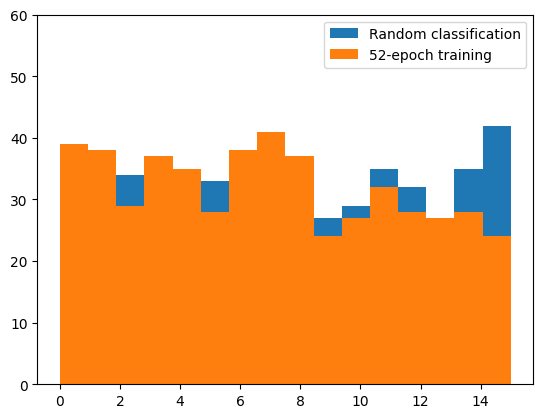

In [48]:
import matplotlib.pyplot as plt
#import seaborn as sns
classifications_per_key_nibble = np.sum(per_trace, axis=0)
rand = np.random.uniform(low=np.min(classifications_per_key_nibble), high=np.max(classifications_per_key_nibble), size=classifications_per_key_nibble.shape)
plt.hist(np.argmax(np.argsort(rand, axis=1)[:, ::-1] == key[:, np.newaxis], axis=1), bins=16, label="Random classification")
plt.hist(np.argmax(np.argsort(classifications_per_key_nibble, axis=1)[:, ::-1] == key[:, np.newaxis], axis=1), bins=16, label="52-epoch training")
plt.legend()
plt.ylim([0, 60])
plt.show()

In [17]:
BINS = 10
REPEAT = 500
mean_ranks = np.zeros((per_trace.shape[1], BINS), dtype=np.longfloat)
for bin_, n_traces in enumerate(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)):
    print(bin_)
    rank = np.zeros(per_trace.shape[1], dtype=int)
    for _ in range(REPEAT):
        print(_, end="\r")
        subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
    mean_ranks[:, bin_] = rank / REPEAT

0
199
299
399
499
599
699
799
899
999
109


KeyboardInterrupt: 

In [26]:
with open("mean_ranks.pic", "wb") as w:
    pic.dump(mean_ranks, w)

In [78]:
np.where(11.5 < mean_ranks[:, 1])

(array([309], dtype=int64),)

In [79]:
mean_ranks[309]

array([12.   , 11.548, 13.094, 13.91 , 14.45 , 14.732, 14.896, 14.978,
       15.   , 15.   ], dtype=float64)

In [80]:
key[309]

3

In [81]:
classifications_per_key_nibble[309]

array([-87347.55974512, -87365.38989944, -87366.58584708, -87407.51293852,
       -87366.92281997, -87380.47702296, -87368.94998754, -87377.48321835,
       -87349.72802504, -87358.36130503, -87358.18039714, -87384.985274  ,
       -87359.22427341, -87376.81066897, -87369.31325142, -87383.66947743])

In [82]:
np.argsort(classifications_per_key_nibble[309])[::-1]

array([ 0,  8, 10,  9, 12,  1,  2,  4,  6, 14, 13,  7,  5, 15, 11,  3],
      dtype=int64)

In [84]:
np.where(mean_ranks[:, 1] < 3.9)

(array([313], dtype=int64),)

In [86]:
mean_ranks[313]

array([2.   , 3.566, 1.938, 1.318, 0.736, 0.278, 0.132, 0.036, 0.008,
       0.   ], dtype=float64)

In [87]:
key[313]

13

In [88]:
classifications_per_key_nibble[313]

array([-87841.21172536, -87812.76424434, -87821.26203466, -87817.13460814,
       -87804.26470582, -87807.29249646, -87821.90757186, -87816.57464167,
       -87837.75253259, -87828.89715528, -87825.46354496, -87814.46414676,
       -87817.43690405, -87783.42027337, -87820.66250903, -87836.43719248])

In [89]:
np.argsort(classifications_per_key_nibble[313])[::-1]

array([13,  4,  5,  1, 11,  7,  3, 12, 14,  2,  6, 10,  9, 15,  8,  0],
      dtype=int64)

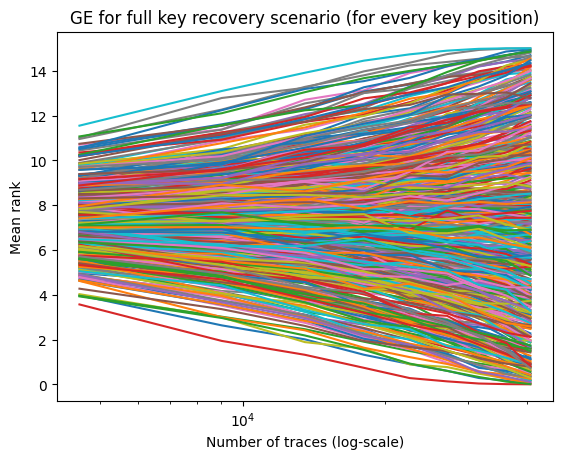

In [90]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}")
plt.xscale("log")
plt.title("GE for full key recovery scenario (for every key position)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
#plt.legend()
plt.show()

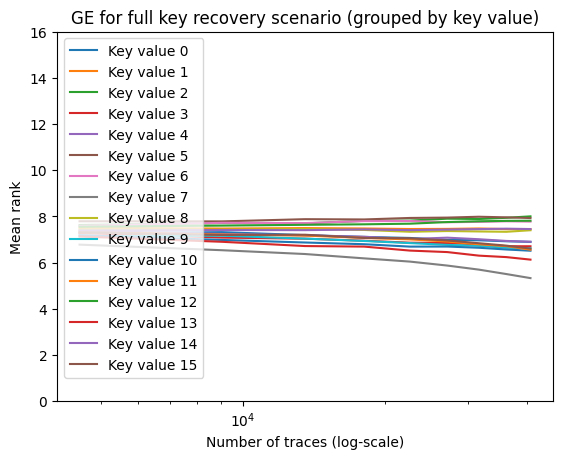

In [120]:
from utils import KEY_ALPHABET
for k in KEY_ALPHABET:
    mean_ranks[key == k]
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:-1], np.mean(mean_ranks[key == k], axis=0)[1:], label=f"Key value {k}")
plt.xscale("log")
plt.title("GE for full key recovery scenario (grouped by key value)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.legend()
plt.ylim([0, 16])
plt.show()